1. Instalar e importar as bibliotecas necessárias

In [64]:
import cv2
import tensorflow as tf
import os
import imghdr
import numpy as np
from matplotlib import pyplot as plt

2. Carregar as imagens

Primeiro, separar as imagens por categorias com base na planilha disponibilizada no dataset!

In [ ]:
import csv
import os
import shutil

# Inicializando contadores para cada classe
counts = {
    'MEL': 0,
    'NV': 0,
    'BCC': 0,
    'AK': 0,
    'BKL': 0,
    'DF': 0,
    'VASC': 0,
    'SCC': 0,
    'UNK': 0
}

input_dir = '../data/ISIC_2019_Training_Input'
output_dir = '../data/sorted_images'


os.makedirs(output_dir, exist_ok=True)
for classe in counts.keys():
    os.makedirs(os.path.join(output_dir, classe), exist_ok=True)

# Lendo o arquivo CSV
with open('../data/ISIC_2019_Training_GroundTruth.csv', 'r') as file:
    reader = csv.reader(file)
    
    # Ignorando o cabeçalho
    next(reader)
    
    # Processando cada linha
    for row in reader:
        image_name = row[0]
        # Convertendo os valores de string para float
        values = list(map(float, row[1:]))
        
        # Atualizando contadores
        if values[0] == 1.0:
            counts['MEL'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'MEL', image_name + '.jpg'))
        if values[1] == 1.0:
            counts['NV'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'NV', image_name + '.jpg'))
        if values[2] == 1.0:
            counts['BCC'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'BCC', image_name + '.jpg'))
        if values[3] == 1.0:
            counts['AK'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'AK', image_name + '.jpg'))
        if values[4] == 1.0:
            counts['BKL'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'BKL', image_name + '.jpg'))
        if values[5] == 1.0:
            counts['DF'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'DF', image_name + '.jpg'))
        if values[6] == 1.0:
            counts['VASC'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'VASC', image_name + '.jpg'))
        if values[7] == 1.0:
            counts['SCC'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'SCC', image_name + '.jpg'))
        if values[8] == 1.0:
            counts['UNK'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'UNK', image_name + '.jpg'))

# Exibindo os resultados
for classe, count in counts.items():
    print(f'{classe}: {count}')

Agora, de fato, carregar as imagens no kera.

Found 25331 files belonging to 8 classes.


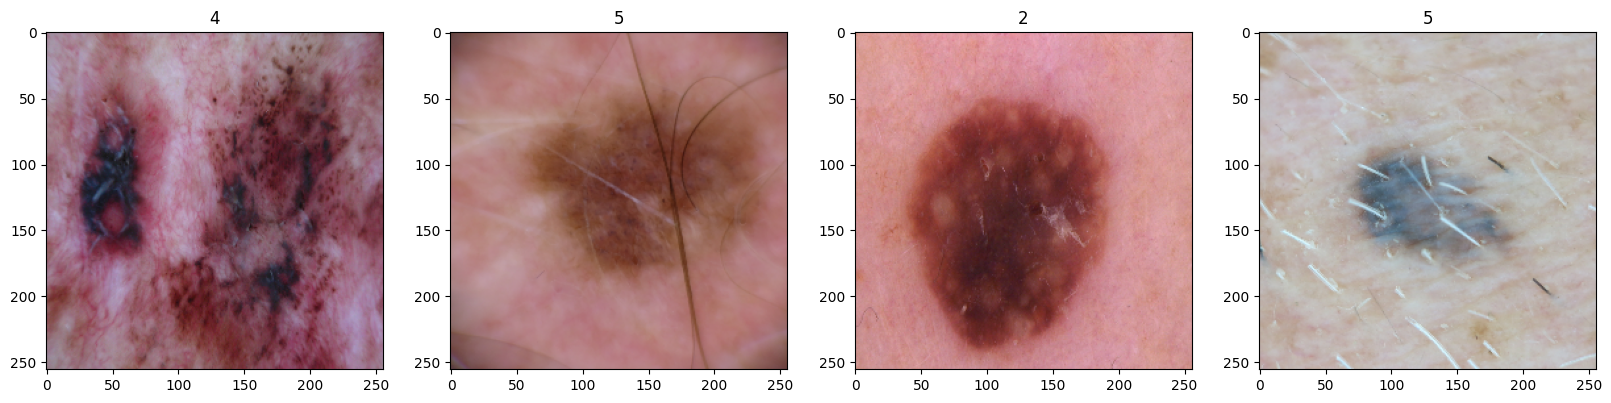

In [71]:
data = tf.keras.utils.image_dataset_from_directory('./data/sorted_images') # Carregando imagens do diretório

data_iterator = data.as_numpy_iterator() # Criando um iterador para acessar os dados

batch = data_iterator.next() # Carregando um batch de imagens

fig, ax = plt.subplots(ncols=4, figsize=(20,20)) # Criando uma figura com 4 subplots
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# Exibindo a figura

3. Separar as imagens
Separar os dados em 70% treinamento, 20% validação e 10% teste. O número de lotes vai depender do tamanho total da amostra!

In [72]:
data = data.map(lambda x,y: (x/255, y)) # Normalizando as imagens
data.as_numpy_iterator().next() # Carregando um batch de imagens

train_size = int(len(data) * .7) # O conjunto de treino terá 70% dos dados
val_size = int(len(data) * .2) # O conjunto de validação terá 20%
test_size = int(len(data)* .1) # O conjunto de teste terá 10%

train = data.take(train_size) # Pegando os primeiros 70% dos dados
val = data.skip(train_size).take(val_size) # Pegando os próximos 20% dos dados
test = data.skip(train_size+val_size).take(test_size) # Pegando os últimos 10% dos dados

# Verificando um batch
for batch in train.take(1):
    images, labels = batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


4. Construir o modelo 

- MaxPooling2D -> condensa a imagem para baixo;

- Otimização -> Adam, para ajuste de pesos e minimizar perdas

- Binary Crossentropy -> computa a perda de entropia cruzada entre labels verdadeiros e labels preditados.

In [81]:
from tensorflow.keras.models import Sequential # import sequential API. Sequential is good for 1 data input.

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # import needed layers

from tensorflow.keras.callbacks import TensorBoard

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.utils import to_categorical

import tensorflow as tf

from sklearn.model_selection import GridSearchCV


In [84]:
train = train.map(lambda x, y: (x, to_categorical(y, num_classes=8)))
val = val.map(lambda x, y: (x, to_categorical(y, num_classes=8)))
    
model = Sequential() # Criação do Modelo

# 1a camada: convolução tem 16 filtros.
# Relu substitui valores nulos
model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(256,256,3)))

# 2a camada: escolhe um valor máximo pós ativação do relu (2 x 2)
model.add(MaxPooling2D())

# 3a camada: saída é apenas 1 valor, usa 32 filtros
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))

# 4a camada:
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())

# Faz flatten dos valores
model.add(Flatten())

# A convolução tem duas camadas densas
model.add(Dense(256, activation='relu')) # Saída são 256 valores
model.add(Dense(8, activation='softmax')) # Saída são 8 valores

#tf.losses.CategoricalCrossentropy()
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



c:\Users\erick\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,206,328 (16.05 MB)

 Trainable params: 4,206,328 (16.05 MB)

 Non-trainable params: 0 (0.00 B)

5. Treinar o modelo

In [75]:
# Treinando o modelo (o y agora é parte do dataset)
hist = model.fit(train, validation_data=val, epochs=11)

# hist.history

Epoch 1/11
554/554 ━━━━━━━━━━━━━━━━━━━━ 213s 382ms/step - accuracy: 0.5347 - loss: 1.3461 - val_accuracy: 0.5756 - val_loss: 1.1749
Epoch 2/11
554/554 ━━━━━━━━━━━━━━━━━━━━ 192s 347ms/step - accuracy: 0.5895 - loss: 1.1478 - val_accuracy: 0.5938 - val_loss: 1.1164
Epoch 3/11
554/554 ━━━━━━━━━━━━━━━━━━━━ 195s 353ms/step - accuracy: 0.6160 - loss: 1.0696 - val_accuracy: 0.6143 - val_loss: 1.0950
Epoch 4/11
554/554 ━━━━━━━━━━━━━━━━━━━━ 196s 353ms/step - accuracy: 0.6441 - loss: 0.9889 - val_accuracy: 0.6208 - val_loss: 1.0711
Epoch 5/11
554/554 ━━━━━━━━━━━━━━━━━━━━ 202s 365ms/step - accuracy: 0.6802 - loss: 0.8897 - val_accuracy: 0.6234 - val_loss: 1.0683
Epoch 6/11
554/554 ━━━━━━━━━━━━━━━━━━━━ 257s 463ms/step - accuracy: 0.7223 - loss: 0.7752 - val_accuracy: 0.6193 - val_loss: 1.1180
Epoch 7/11
554/554 ━━━━━━━━━━━━━━━━━━━━ 237s 427ms/step - accuracy: 0.7744 - loss: 0.6401 - val_accuracy: 0.6131 - val_loss: 1.2491
Epoch 8/11
554/554 ━━━━━━━━━━━━━━━━━━━━ 173s 313ms/step - accuracy: 0.8248 -

In [ ]:
print(hist.history)

# model.save('mnist_model.keras')
